In [1]:
### Import packages ###
import time, sys, os
import h5py
import numpy as np
import astropy as ap
import scipy
import pandas
from matplotlib.pyplot import *

# Import packages to display SDSS optical image
from PIL import Image
import requests

# Import packages to open fits and calculate cosmology
from astropy.io import fits
from astropy.cosmology import WMAP9
import astropy.coordinates as coord
from astroquery.sdss import SDSS
from scipy.io import readsav

# Import prospector 
sys.path.insert(0, '/mnt/c/Users/emma_d/ASTR_Research/lib/python3.8/site-packages/repo/prospector/')
import prospect     #likelihood evaluations, parameter priors, and posterior sampling
from prospect.models.templates import TemplateLibrary
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
from prospect.likelihood import chi_spec, chi_phot
from prospect.fitting import fit_model
from prospect.io import write_results as writer
import prospect.io.read_results as reader
import fsps

import corner

# Import MCMC package
import emcee

# Import my build functions
from build_model_funct import build_model
from build_obs_funct_Win import build_obs
from FracSFH_ import FracSFH

import seaborn as sns
my_cmap = sns.color_palette("tab10")
import os
import tables

### re-defining plotting defaults for matplotlib
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})
rcParams.update({'axes.facecolor':'w'})
rcParams.update({'savefig.facecolor':'w'})
rcParams.update({'lines.linewidth':'0.7'})
rcParams.update({'font.size':'16'})

rcParams.update({'axes.prop_cycle': cycler(color = sns.color_palette("tab10"))})
%matplotlib inline

In [2]:
### Start Timer ###
start_time = time.time()

In [3]:
### Control for SEDs ###
Show_all_SEDS = False
Specific_galaxy = 25

Comp_Path = 'Comparison/G{}/'.format(Specific_galaxy)

if not os.path.exists('{}'.format(Comp_Path)):
    os.mkdir('{}'.format(Comp_Path))
Galaxy_Path = '{}'.format(Comp_Path)

print('This is for Galaxy ', Specific_galaxy)

ts = time.strftime("%y%b%d", time.localtime())
print('The Date is', ts)

This is for Galaxy  25
The Date is 21Jul20


In [4]:
### Constants ###
lsun = 3.846e33
pc = 3.085677581467192e18 # in cm
lightspeed = 2.998e18 # AA/s
to_cgs = lsun/(4.0 * np.pi * (pc*10)**2)
jansky_mks = 1e-26

### My Unit Functions ###
def mJy_to_maggies(mJy):
    """ Converts mJy to maggies
    """
    conversion_mJy_Jy = .001
    conversion_mJy_maggie = 3631
    return mJy * conversion_mJy_Jy/conversion_mJy_maggie

def f_nu_to_f_lambda_maggie(lam, f_nu):
    """ Converts f_nu (ergs) to f_lambda (maggies)
    """
    f_lambda_ergs = (10**-17 * f_nu) * (lam**2)/lightspeed
    f_lambda_mJy = (f_lambda_ergs / (1E-23)) * 1000
    f_lambda_maggie = mJy_to_maggies(f_lambda_mJy)
    return f_lambda_maggie

### From GitHub ###
def get_best_v2(res, **kwargs):
    """ Get the maximum a posteriori parameters.
    """
    imax = np.argmax(res['lnprobability'])
    try:
        i, j = np.unravel_index(imax, res['lnprobability'].shape)
        theta = res['chain'][i, j, :].copy()
    except(ValueError):
        theta = res['chain'][imax, :].copy()
        
    return  theta

def build_sps(zcontinuous=1, **extras):
    """ Build sps object using FracSFH basis
    """
    sps = FracSFH(zcontinuous = 1, **extras)         # run_params
    return sps

def zfrac_to_masses(total_mass=None, z_fraction=None, agebins=None, **extras):
    """This transforms from independent dimensionless `z` variables to sfr
    fractions and then to bin mass fractions. The transformation is such that
    sfr fractions are drawn from a Dirichlet prior.  See Betancourt et al. 2010
    and Leja et al. 2017
    :param total_mass:
        The total mass formed over all bins in the SFH.
    :param z_fraction:
        latent variables drawn form a specific set of Beta distributions. (see
        Betancourt 2010)
    :returns masses:
        The stellar mass formed in each age bin.
    """
    # sfr fractions
    sfr_fraction = np.zeros(len(z_fraction) + 1)
    sfr_fraction[0] = 1.0 - z_fraction[0]
    for i in range(1, len(z_fraction)):
        sfr_fraction[i] = np.prod(z_fraction[:i]) * (1.0 - z_fraction[i])
    sfr_fraction[-1] = 1 - np.sum(sfr_fraction[:-1])

    # convert to mass fractions
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    mass_fraction = sfr_fraction * np.array(time_per_bin)
    mass_fraction /= mass_fraction.sum()

    masses = total_mass * mass_fraction
    return masses


def zfrac_to_sfr(total_mass=None, z_fraction=None, agebins=None, **extras):
    """This transforms from independent dimensionless `z` variables to SFRs.
    :returns sfrs:
        The SFR in each age bin (msun/yr).
    """
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    masses = zfrac_to_masses(total_mass, z_fraction, agebins)
    return masses / time_per_bin

def best_vals(result_list):
    # print(corner.quantile(result_list[param_order], [0.16, 0.5, 0.84]))
    q_16, q_50, q_84 = corner.quantile(result_list, [0.16, 0.5, 0.84]) 
    dx_down, dx_up = q_50-q_16, q_84-q_50
    # return (np.around(q_50,2), np.around(dx_up,2), np.around(dx_down,2))
    return q_50, dx_up, dx_down

print('Packages and Functions Loaded')

Packages and Functions Loaded


In [5]:
### Load in Data file for all galaxies ###
AGN_file = fits.open('/mnt/c/Users/emma_d/ASTR_Research/Data/asu.fit')
AGN_data = AGN_file[1].data

In [6]:
### Find all h5 files in Galaxy_output directory and subdirectories and append to h5files ###
h5_path = '/mnt/c/Users/emma_d/ASTR_Research/Galaxy_output/CAPS_Output'

h5files = []
h5files_dir = []
for dirpath, subdirs, files in os.walk(h5_path):
    for y in subdirs:
        for dirpath, subdirs, files in os.walk(h5_path + '/' + str(y)):
            for x in files:
                if x.endswith(".h5"):
                    h5files.append(os.path.join(dirpath, x))

In [7]:
### Load in data from h5file ###
all_results = []
all_obs = []
all_sps = []
all_model = []

zred_a = []
wphot = []
wspec = []

theta_bestfit = []
mspec_map = []
mphot_map = []

mspec_agn_inv = []
mphot_agn_inv = []

Gal_desig = []
Gal_logmass = []
Gal_data = []

names = []
G_names = []
G_numbers = []
num_runs = len(h5files)
progress_meter = 1
for i in range(0, len(h5files)):
    names.append(os.path.basename(h5files[i]))

    if names[i][2] == '_':
        G_names.append(names[i][0:2])
    else:
        G_names.append(names[i][0:3])
    
    G_numbers.append(int(G_names[i][1:]))
    number_g = int(G_names[i][1:])

    Gal_data.append(AGN_data[number_g])
    Gal_desig.append(Gal_data[i][1])
    Gal_logmass.append(Gal_data[i][50])

    all_results.append(reader.results_from(h5files[i], dangerous=False)[0])
    all_obs.append(reader.results_from(h5files[i], dangerous=False)[1])
    all_sps.append(build_sps(**all_results[i]['run_params']))
    all_model.append(build_model(**all_results[i]['run_params']))
    
    theta_bestfit.append(all_results[i]['bestfit']['parameter'])

    agn_only_theta = theta_bestfit[i].copy()
    agn_only_theta[13] = 0

    no_AGN_theta = all_results[i]['bestfit']['parameter'].copy()
    no_AGN_theta[13] = 0
    No_AGN_model = build_model(**all_results[i]['run_params'])
    mspec_agn_inv.append(No_AGN_model.mean_model(no_AGN_theta, all_obs[i], sps=all_sps[i])[0])      # mspec_agn_inv
    mphot_agn_inv.append(No_AGN_model.mean_model(no_AGN_theta, all_obs[i], sps=all_sps[i])[1])
    
    redshift = next(item for item in all_results[i]['model_params'] if item["name"] == "zred")
    zred_a.append(1.0 + redshift['init'])
    
    wphot.append(all_obs[i]['phot_wave'])

    wspec_wave = all_sps[i].wavelengths
    wspec.append(zred_a[i] * wspec_wave)

    mean_model = all_model[i].mean_model(theta_bestfit[i], all_obs[i], sps=all_sps[i])
    mspec_map.append(mean_model[0])
    mphot_map.append(mean_model[1])

    print(G_names[i], Gal_desig[i], Gal_logmass[i], '\t{:.0f}'.format(progress_meter/num_runs * 100),'% Done loading file data')
    progress_meter += 1

tables.file._open_files.close_all()
print('There are',num_runs, 'runs')
print('Finished')

G25 EAH17 10.05 	100 % Done loading file data
There are 1 runs
Finished


In [8]:
# for i in range(0,len(h5files)):
#     try:
#         print(all_results[i]['run_params']['ts'], G_names[i])
#     except:
#         print('No ts available for', os.path.basename(h5files[i]))
#     try:
#         print(all_results[i]['run_params']['ra_labels'])
#     except:
#         print('No ra_labels available')

In [9]:
### Plot SEDs of galaxy runs ###
if Show_all_SEDS == True:
      ymin = 1.5 * (10**-10)
      xmin = 1222.447801222852 
      xmax = 6164346.25 
      ymax = 0.0005315684384467088

      fig, axes = subplots(nrows= num_runs, ncols = 1, sharex=True, sharey=True, figsize=(16, 2 * num_runs), dpi=300)
      gs = gridspec.GridSpec(num_runs, 1, hspace=0.0) 

      ax_counter = 0

      for ax in axes.flat:
            ax= subplot(gs[ax_counter])
            ax.loglog(wspec[ax_counter] * zred_a[ax_counter], mspec_map[ax_counter], 
                  label='Model spectrum (MAP)',lw=0.7,  alpha=0.7, color = my_cmap[0]) 
            
            ax.errorbar(wphot[ax_counter], mphot_map[ax_counter], 
                  label='Model photometry (MAP)', marker='s', markersize=10, alpha=0.8, 
                  ls='', lw=3,  markerfacecolor='none', color = my_cmap[0], markeredgewidth=3) 
            
            ax.errorbar(wphot[ax_counter], all_obs[ax_counter]['maggies'], 
                  yerr=all_obs[ax_counter]['maggies_unc'], label='Observed photometry', 
                  ecolor= my_cmap[3], marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
                  markerfacecolor='none', markeredgecolor=my_cmap[3], markeredgewidth=3)
            
            ax.legend(title=G_names[ax_counter], loc=2)
            
            ax.set_xlim([xmin, xmax])
            ax.set_ylim([ymin, ymax])
            ax_counter +=1

      ax.set_xlabel('Wavelength [A]')
      tight_layout()
else:
      print('Show_all_SEDs is False. \nTo see SEDs for all runs, turn Show_all_SEDs to True')

Show_all_SEDs is False. 
To see SEDs for all runs, turn Show_all_SEDs to True


In [10]:
Specific_galaxy_index = []
if Specific_galaxy in G_numbers:
    for i in range(0,len(G_numbers)):
        if G_numbers[i] == Specific_galaxy:
            Specific_galaxy_index.append(i)
    print('There are', len(Specific_galaxy_index), 'runs for G{0}:\t{1}'.format(Specific_galaxy, Specific_galaxy_index))
else:
    print('There are no runs available for galaxy G{0}'.format(Specific_galaxy))

There are 1 runs for G25:	[0]


In [11]:
optical_spectrum = SDSS.get_spectra(plate= all_results[Specific_galaxy_index[0]]['run_params']['SDSS_Query']['plate'][0], 
    fiberID= all_results[Specific_galaxy_index[0]]['run_params']['SDSS_Query']['fiberID'][0], 
    mjd= all_results[Specific_galaxy_index[0]]['run_params']['SDSS_Query']['mjd'][0])[0] 

/home/emma/.local/lib/python3.8/site-packages/astroquery/sdss/core.py:862: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)>

In [ ]:
### Grab SDSS Data ###
Gal_RA = all_results[Specific_galaxy_index[0]]['run_params']['SDSS_Query']['ra'][0]
Gal_DEC = all_results[Specific_galaxy_index[0]]['run_params']['SDSS_Query']['dec'][0]

SDSS_scale = 0.396127                   # arcsec/pix
SDSS_width = 128                        # SDSS_arcsec/SDSS_scale

print(Gal_RA, Gal_DEC)

SDSS_URL = 'http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?TaskName=Skyserver.Chart.List&ra={0}&dec={1}&width={2}&height={2}&scale={3}'.format(Gal_RA, Gal_DEC, SDSS_width, SDSS_scale) # &width={2}&height={2}&scale={3}  : , SDSS_width, SDSS_scale
SDSS_Image = Image.open(requests.get(SDSS_URL, stream=True).raw)

optical_spectrum = SDSS.get_spectra(plate= all_results[Specific_galaxy_index[0]]['run_params']['SDSS_Query']['plate'][0], 
    fiberID= all_results[Specific_galaxy_index[0]]['run_params']['SDSS_Query']['fiberID'][0], 
    mjd= all_results[Specific_galaxy_index[0]]['run_params']['SDSS_Query']['mjd'][0])[0] 

### Obtain optical spectrum in correct units###
optical_spectrum_flux = optical_spectrum[1].data['flux']
optical_spectrum_lam = 10 ** (optical_spectrum[1].data['loglam'])

# Find what units the data is in
units_flux = optical_spectrum[0].header['bunit']
units_wavelength_full = optical_spectrum[0].header['WAT1_001']
units_wavelength = units_wavelength_full[36:]

# Convert SDSS units to Prospector units
optical_spectrum_flux = f_nu_to_f_lambda_maggie(optical_spectrum_lam, optical_spectrum_flux)       
optical_spectrum_lam = optical_spectrum_lam / (1 + all_results[Specific_galaxy_index[0]]['run_params']['object_redshift'])
optical_spectrum_lines = optical_spectrum[3].data

# ----------------------------------------------------------------------------------------------
### Grab IRS Data ###
if all_results[Specific_galaxy_index[0]]['run_params']['IRS_indicator'] == 1:
    ea_struct = readsav('Data/ea_struct_v9.sav')['ea_struct']
    s1, = np.where(ea_struct.source.astype(str) == 'Spitzer')
    ea_struct = ea_struct[s1]

    gal_EA_Desig = all_results[Specific_galaxy_index[0]]['run_params']['gal_desig'][2:]
    s, = np.where(ea_struct.ea_desig.astype(str) == gal_EA_Desig)

    # Convert Smercina units (mu*m,nu*f_nu) to prospector units (A, maggies)
    IRS_wavelength = ea_struct[s][0].irs_spectrum.wave * 10000
    IRS_flux = mJy_to_maggies(10**13 *(ea_struct[s][0].irs_spectrum.wave/(2.998*10**14)) * ea_struct[s][0].irs_spectrum.flux)

    # Masks where IRS_FLUX is very low (~= 0) : Keeps dips to 0 out of plot
    IRS_wavelength =IRS_wavelength[ IRS_flux > 10**-9 ]
    IRS_flux = IRS_flux[ IRS_flux > 10**-9 ]

# ----------------------------------------------------------------------------------------------
### Plot SDSS and IRS Spectra and image if available ###
fig1 = figure(figsize=(20,5), dpi = 300)
grid = GridSpec(2, 7)

if all_results[Specific_galaxy_index[0]]['run_params']['IRS_indicator'] == 1:
    ax1 = subplot(grid[:2, :2])
    ax2 = subplot(grid[0, 2:7])
    ax3 = subplot(grid[1, 2:7])
else:
    ax1 = subplot(grid[:2, :2])
    ax2 = subplot(grid[0:, 2:7])

ax1.imshow(SDSS_Image, origin='lower')
ax1.set_xticks([0, SDSS_width/2, SDSS_width])
ax1.set_xticklabels(all_results[Specific_galaxy_index[0]]['run_params']['ra_labels'])
ax1.set_yticks([0, SDSS_width/2, SDSS_width])
ax1.set_yticklabels(all_results[Specific_galaxy_index[0]]['run_params']['dec_labels'])
ax1.set_title('G{0}_{1}'.format(all_results[Specific_galaxy_index[0]]['run_params']['galaxy_num'], all_results[Specific_galaxy_index[0]]['run_params']['gal_desig']))


# Plot optical and IRS data if available
ax2.plot(optical_spectrum_lam, optical_spectrum_flux, label='SDSS spectra [maggies]')
y_min, y_max = ax2.get_ylim()

spec_lines = ['[O_II] 3727', '[O_III] 5007', 'H_alpha', '[N_II] 6548', '[N_II] 6583', 'H_beta', 'H_gamma', 'H_epsilon', 'H_delta', '[S_II] 6716', '[S_II] 6730']
spec_lines_short = [r'O[II]', r'O[III]', r'H$_α$', r'N[II]', r'N[II]', r'H$_β$', r'H$_γ$', r'H$_ε$', r'H$_δ$', r'S[II]', r'S[II]']
for i, n in enumerate(spec_lines):
    if (n =='[N_II] 6548' or n =='[N_II] 6583'):
        ax2.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n],  color=my_cmap[8], ymax = 1, ymin = 0, linestyle=(0, (5, 10))) 
        if n =='[N_II] 6548':
            ax2.annotate(spec_lines_short[i], ((6548 + 6583)/2, y_max* 0.5), horizontalalignment='center')
    elif (n =='[S_II] 6716' or n =='[S_II] 6730'):
        ax2.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n], color=my_cmap[9], ymax = 1, ymin = 0, linestyle=(0, (5, 10))) 
        if n == '[S_II] 6716':
            ax2.annotate(spec_lines_short[i], ((6716 + 6730)/2, y_max* 0.85), horizontalalignment='center')
    else:
        ax2.axvline(x=optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n],  color=my_cmap[i], ymax = 1, ymin = 0, linestyle=(0, (5, 10)))
        ax2.annotate(spec_lines_short[i], (optical_spectrum_lines['LINEWAVE'][optical_spectrum_lines['LINENAME']==n], y_max* 0.85), horizontalalignment='center')

ax2.set_xlim(min(optical_spectrum_lam) * .99, 7200)
ax2.set_xlabel('Wavelength [A]')
ax2.set_yscale('log')
ax2.legend(loc=4)

if all_results[Specific_galaxy_index[0]]['run_params']['IRS_indicator'] == 1:
    ax3.plot(IRS_wavelength, IRS_flux, label='IRS spectra [maggies]')
    ax3.set_xlabel('Wavelength [A]')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.legend(loc=4)

tight_layout()

191.215407347697 -1.75992700610755


/home/emma/.local/lib/python3.8/site-packages/astroquery/sdss/core.py:862: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)>

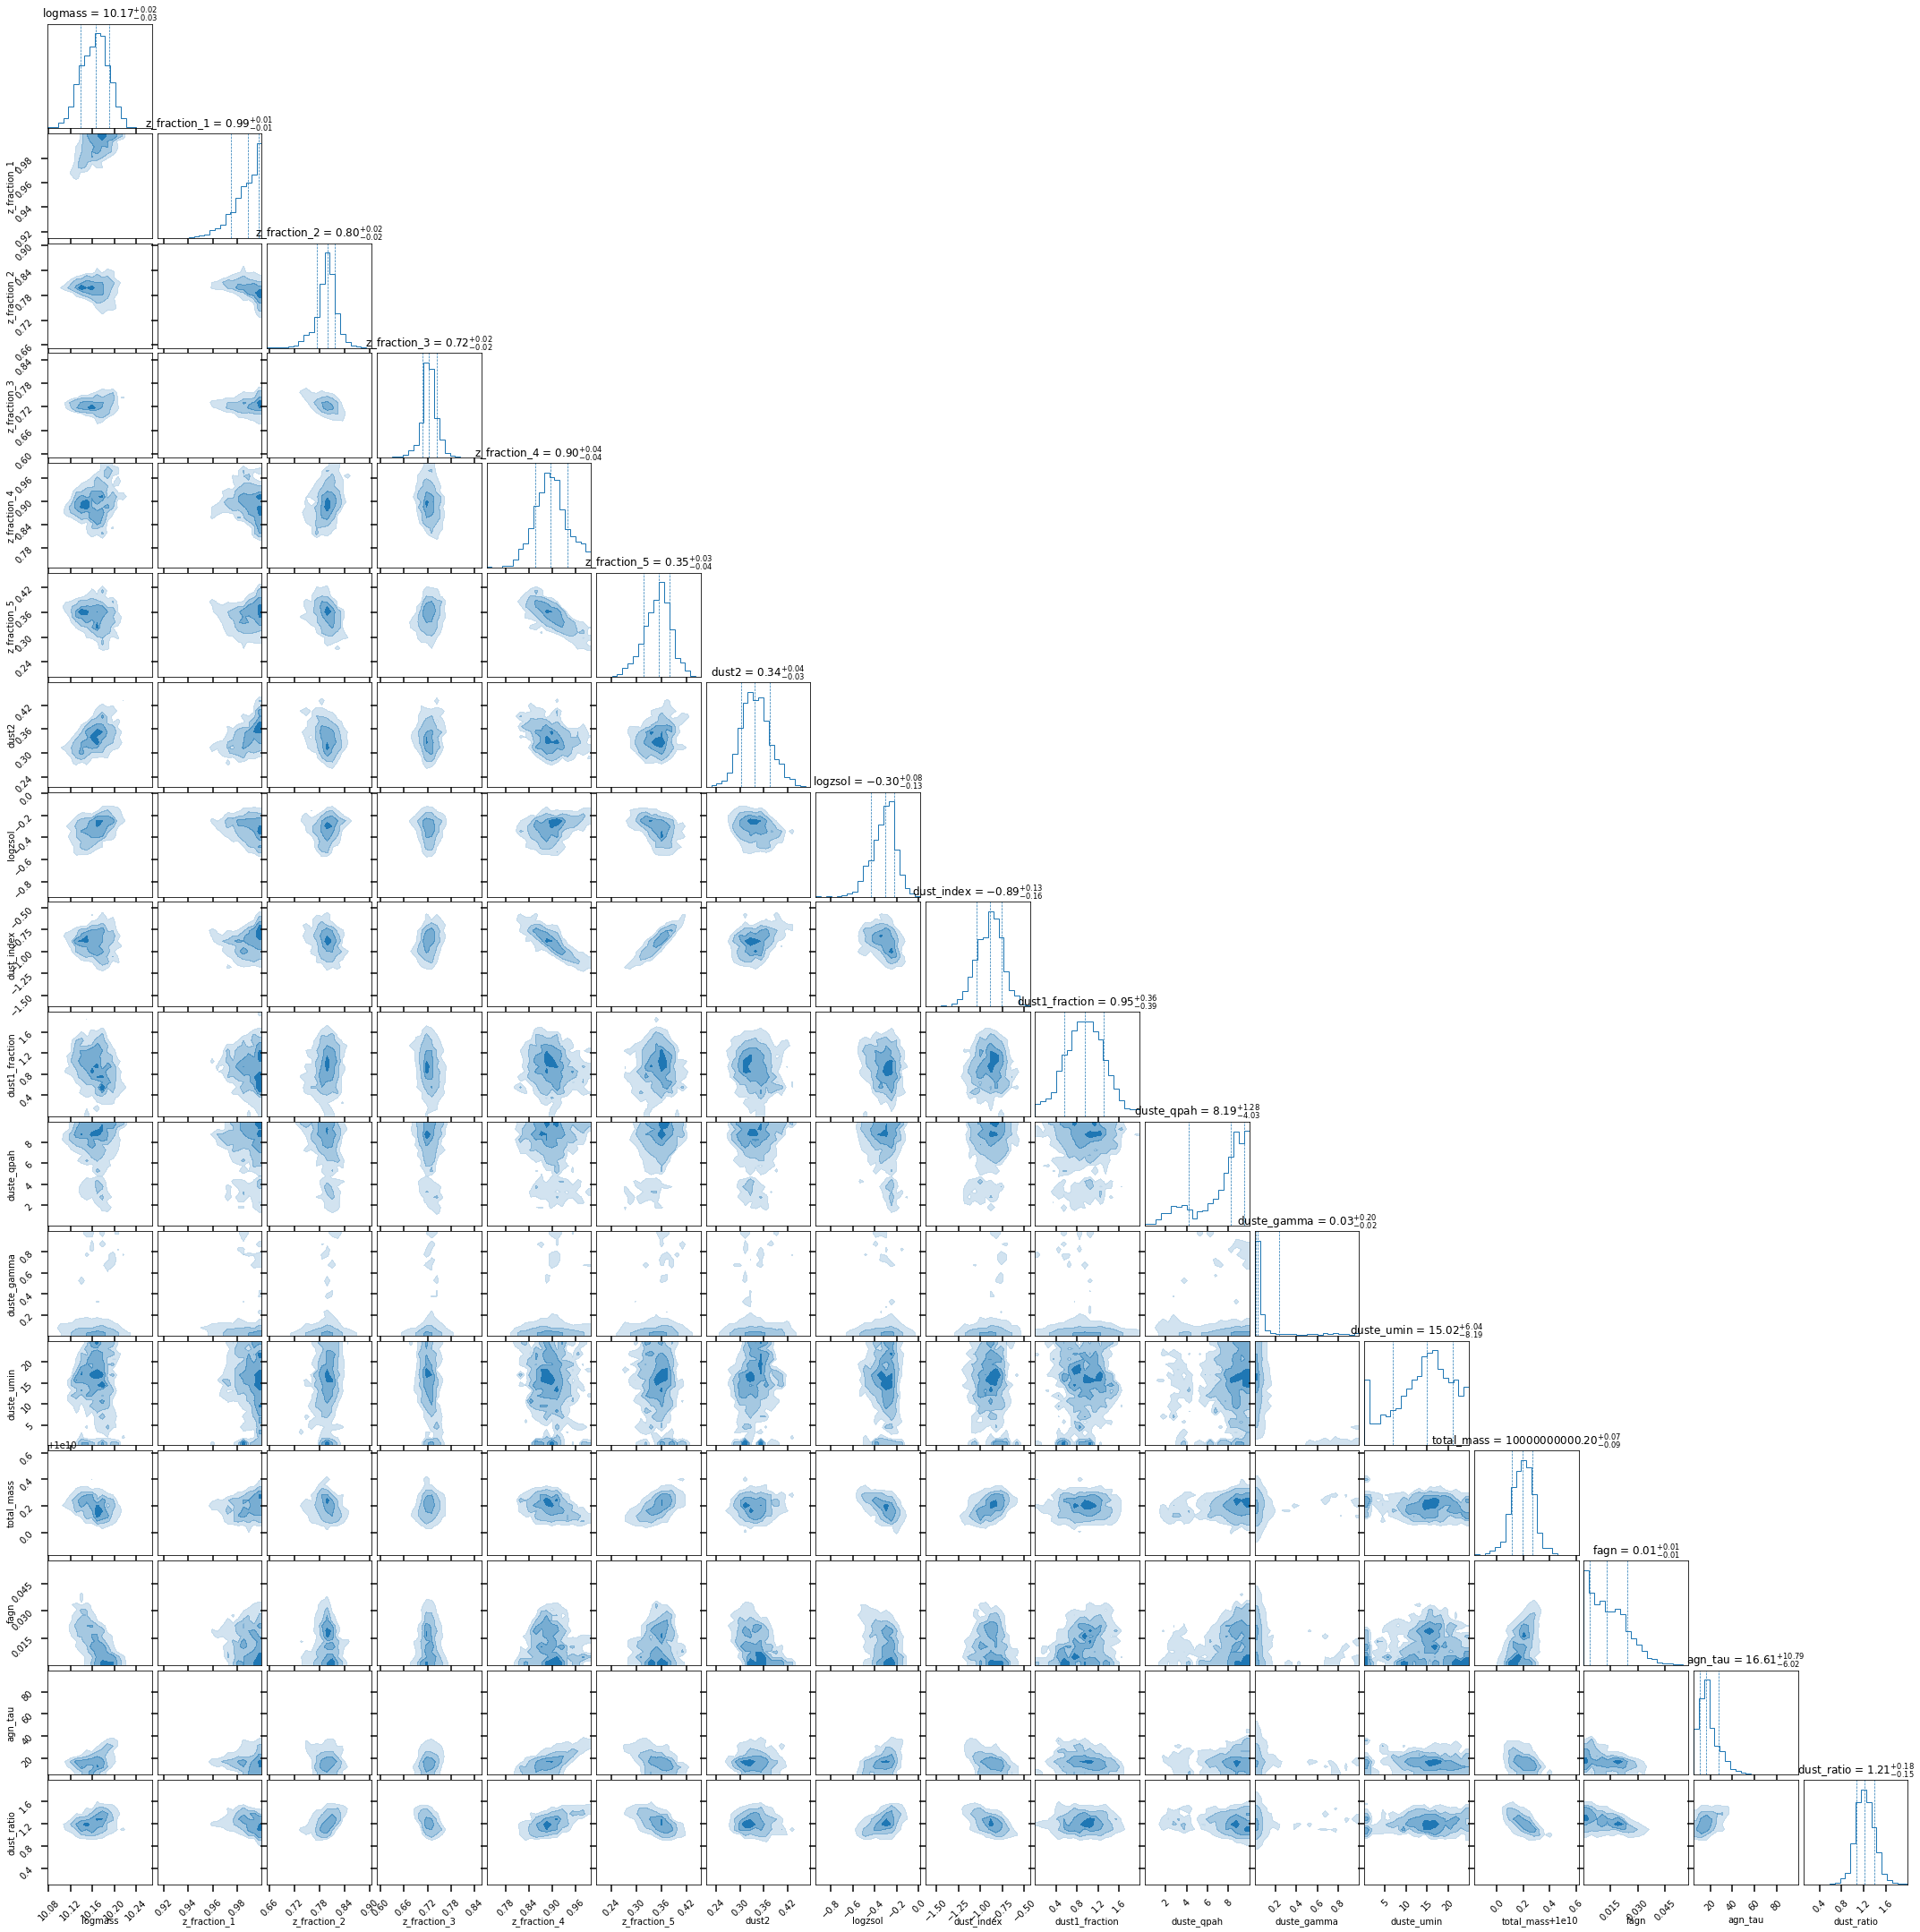

In [ ]:
### Create cornerplot for galaxy runs ###
fig1 = subplots(17, 17,figsize=(30,30))[0]
for i in range(0, len(Specific_galaxy_index)):
    cornerfig = reader.subcorner(all_results[Specific_galaxy_index[i]], start=0 ,fig=fig1, color=my_cmap[i], alpha=0.5) #subplots(17, 17,figsize=(30,30))[0])       # MUST modify subplot(#,#) thin=thin,,  truths= theta_bestfit, 

In [ ]:
### Calculate reduced χ2 for specific galaxy ###
χ2 = [None] * len(Specific_galaxy_index)
χ_array = [None] * len(Specific_galaxy_index)
χ2_DOF = [None] * len(Specific_galaxy_index)
χ_array_mask = [None] * len(Specific_galaxy_index)

for k in range(0, len(Specific_galaxy_index)):
    χ2[k] = np.longdouble(0) # np.float128(0)
    χ2_DOF[k] = 0
    χ_array[k] = np.zeros(len(wphot[Specific_galaxy_index[k]]))
    for i in range(0, len(wphot[Specific_galaxy_index[k]])):
        unc_variable = np.longdouble(all_obs[Specific_galaxy_index[k]]['maggies_unc'][i])
        if unc_variable == 0:
            χ2[k] += 0
            χ_array[k][i] = np.inf
        else:
            χ= np.longdouble(((mphot_map[Specific_galaxy_index[k]][i] - all_obs[Specific_galaxy_index[k]]['maggies'][i])))/unc_variable
            χ_array[k][i] = χ
            χ2[k] += χ**2
            χ2_DOF[k] += 1

    χ_array_mask[k] = [χ_array[k] == np.inf]
    print('Reduced χ2 = ',χ2[k]/χ2_DOF[k], '\tDOF = ', χ2_DOF[k])

Reduced χ2 =  3.758444007055723659 	DOF =  16


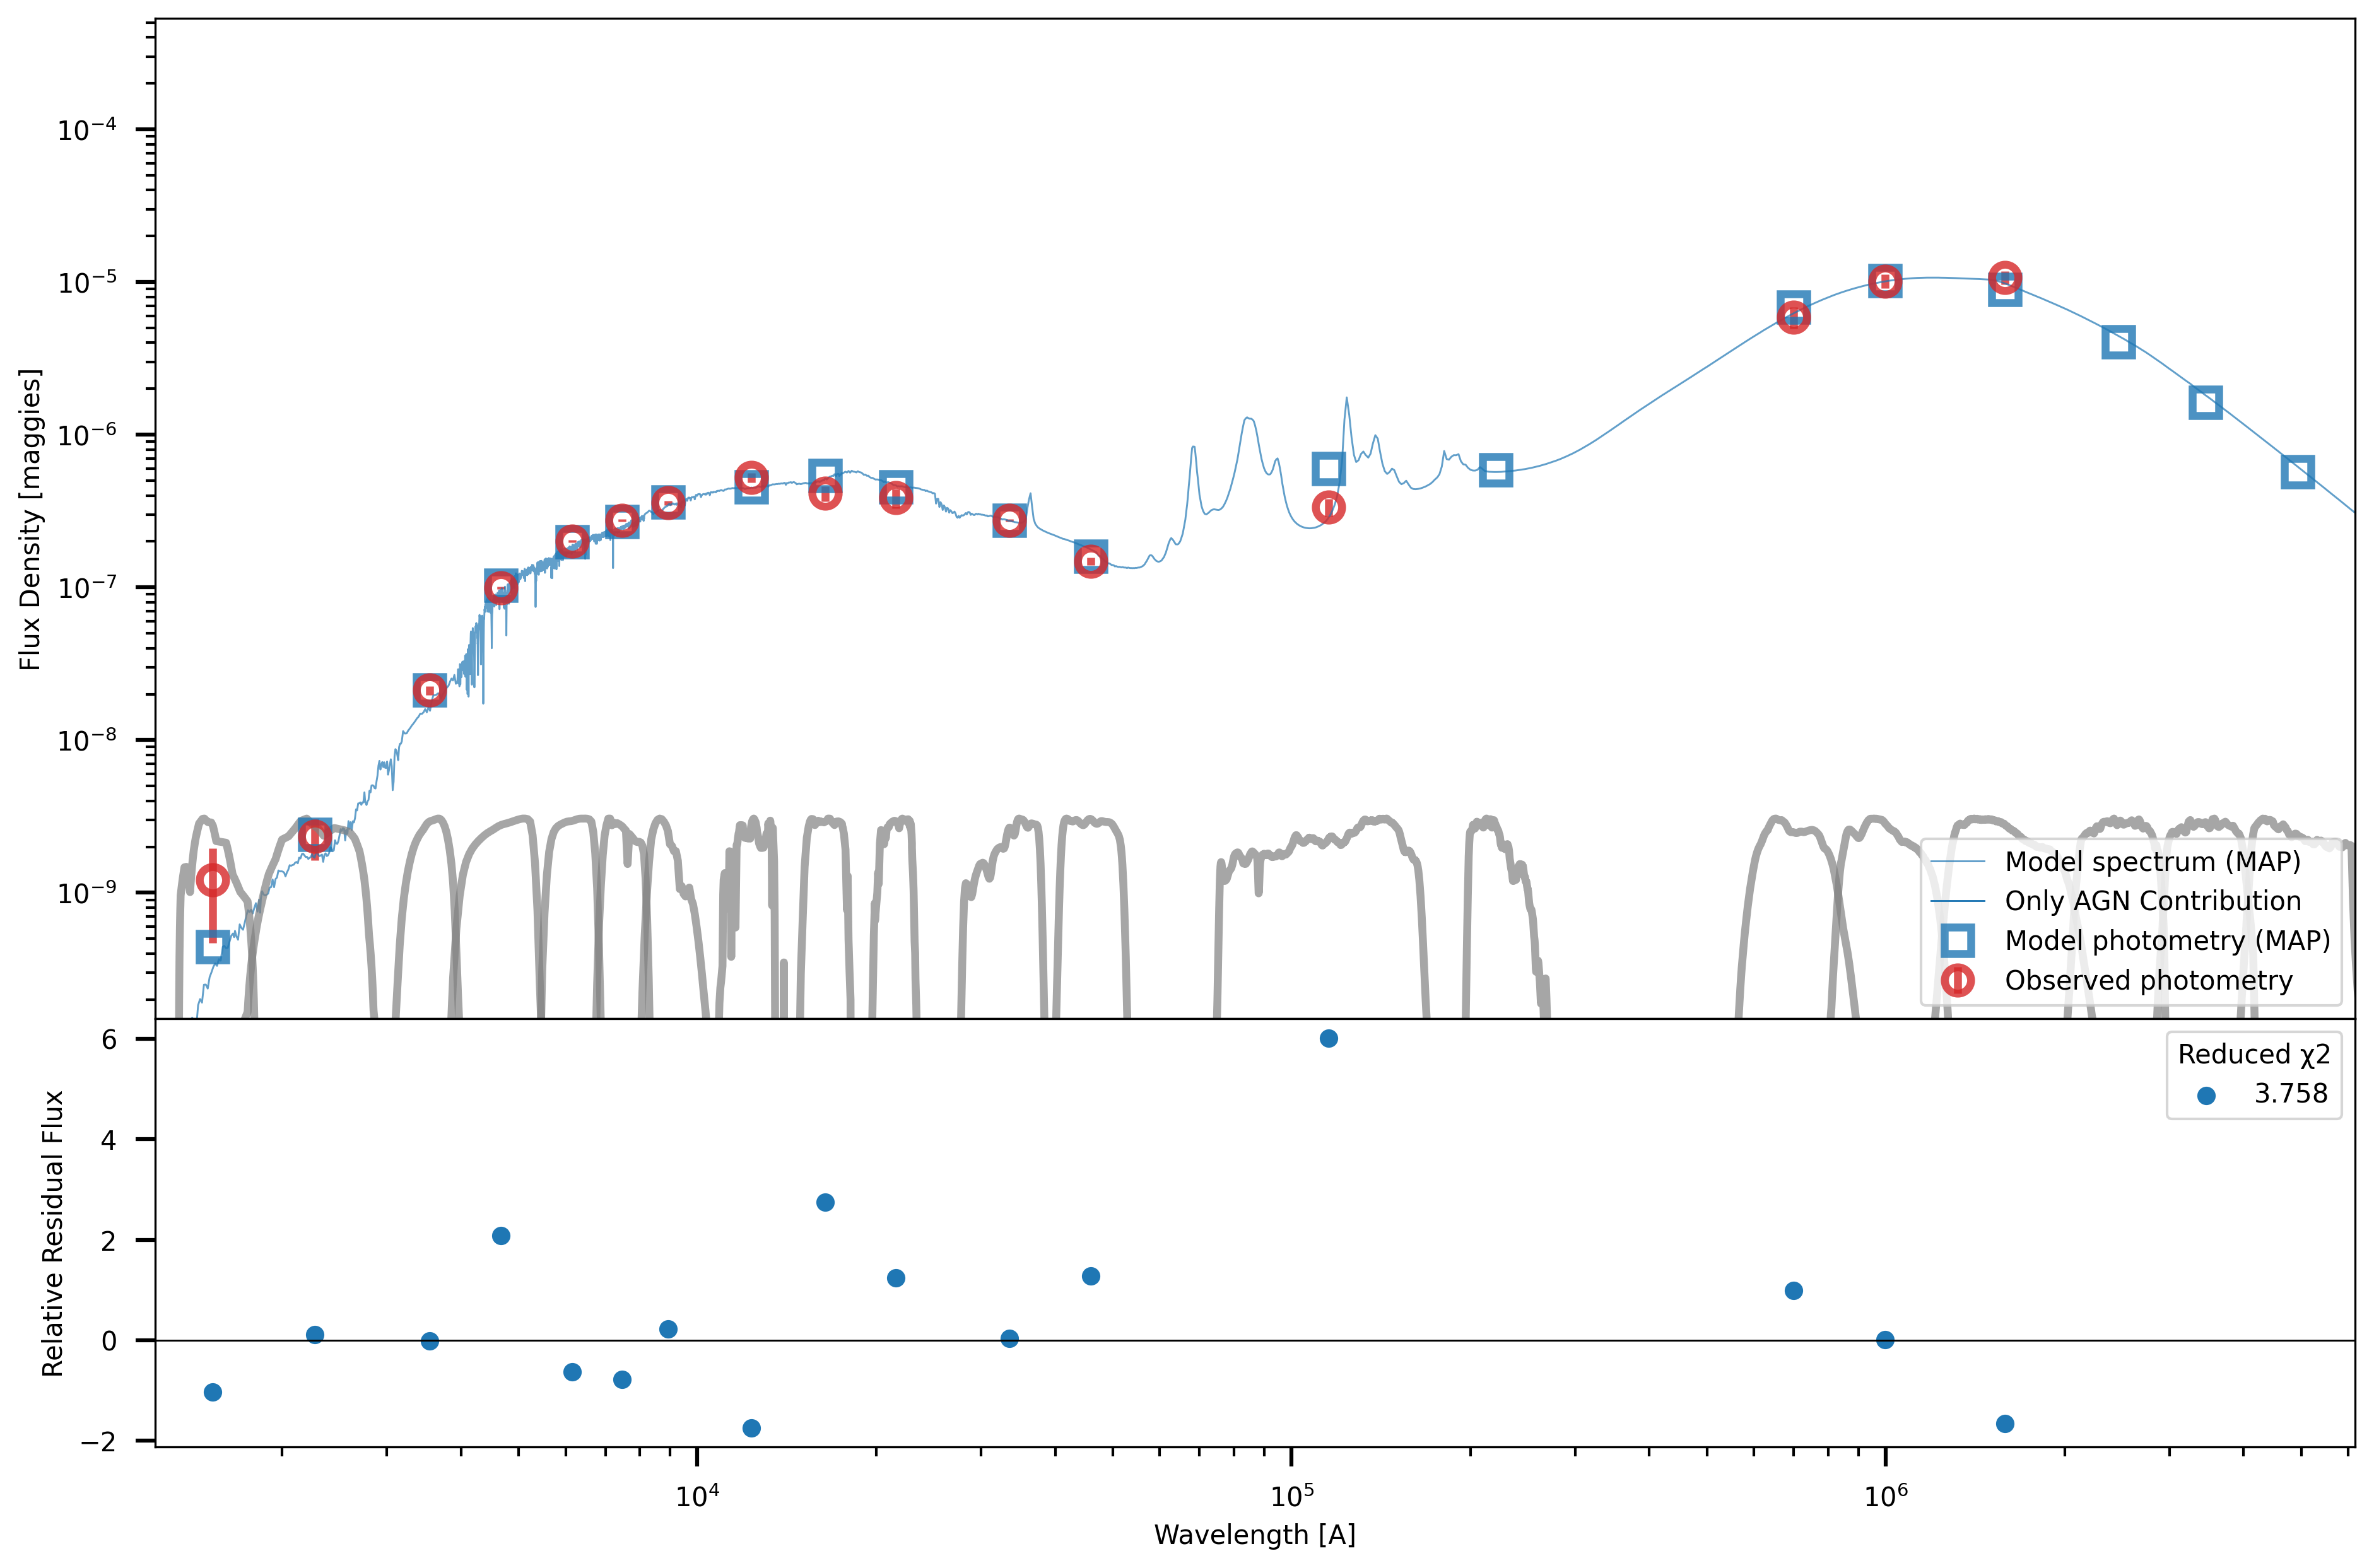

In [ ]:
### Plot SED and Residuals for specific galaxy ###
ymin = 1.5 * (10**-10) #* (1/10000)
ymax = 0.0005315684384467088
xmin = 1222.447801222852 
xmax = 6164346.25 

# Make plot of data and model
fig1 = figure(figsize=(15,10), dpi=300)
ax = [0,0]
grid = GridSpec(10, 1, hspace=0)
ax[0] = subplot(grid[:7, :1])
ax[1] = subplot(grid[7:, :1])

for i in range(0, len(Specific_galaxy_index)):
    # specific_theta_bestfit = all_results[Specific_galaxy_index[i]]['bestfit']['parameter']

    ax[0].loglog(wspec[Specific_galaxy_index[i]] * zred_a[Specific_galaxy_index[i]], mspec_map[Specific_galaxy_index[i]], 
        label='Model spectrum (MAP)',lw=0.7,  alpha=0.7, color = my_cmap[i]) 
            
    ax[0].errorbar(wphot[Specific_galaxy_index[i]], mphot_map[Specific_galaxy_index[i]], 
        label='Model photometry (MAP)', marker='s', markersize=10, alpha=0.8, 
        ls='', lw=3,  markerfacecolor='none', color = my_cmap[i], markeredgewidth=3) 
            
    ### AGN Emission Contribution ###
    mspec_agn = mspec_map[Specific_galaxy_index[i]] - mspec_agn_inv[Specific_galaxy_index[i]]
    ax[0].loglog(wspec[Specific_galaxy_index[i]] * zred_a[Specific_galaxy_index[i]], mspec_agn, label='Only AGN Contribution', color = my_cmap[i]) #, color='orange'

    ### No AGN Contribution ###
    # ax[0].loglog(wspec[Specific_galaxy_index[i]] * zred_a[Specific_galaxy_index[i]], mspec_agn_inv[Specific_galaxy_index[i]], label='No AGN Contribution', color = my_cmap[2])  #, color='purple'

    ax[1].scatter(np.ma.masked_array(wphot[Specific_galaxy_index[i]], mask=χ_array_mask[i]).compressed(),  
        χ_array[i][np.invert(χ_array_mask[i])[0]], color=my_cmap[i], label='{:.3f}'.format(χ2[i]/χ2_DOF[i]))
    ax[1].plot(np.logspace(np.log10(wphot[Specific_galaxy_index[i]].min()) * 0.8, 
        np.log10(wphot[Specific_galaxy_index[i]].max()) * 1.2, len(wphot[Specific_galaxy_index[i]])), 
        np.zeros(len(wphot[Specific_galaxy_index[i]])), 'k-') 

# Plot observed data
ax[0].errorbar(wphot[Specific_galaxy_index[i]], all_obs[Specific_galaxy_index[i]]['maggies'], 
    yerr=all_obs[Specific_galaxy_index[i]]['maggies_unc'], label='Observed photometry', 
    ecolor= my_cmap[3], marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
    markerfacecolor='none', markeredgecolor=my_cmap[3], markeredgewidth=3)


# Plot transmission curves
for f in all_obs[0]['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    ax[0].loglog(w, t, lw=3, color='gray', alpha=0.7)


ax[0].set_ylabel('Flux Density [maggies]')
ax[0].set_xlim([xmin, xmax])
ax[0].set_ylim([ymin, ymax])
ax[0].legend(loc=4)
# ax[0].set_title('{0}_MAP_SED_7'.format(run_params['ID']))

ax[1].set_xscale('log')
ax[1].set_ylabel('Relative Residual Flux')
ax[1].set_xlabel('Wavelength [A]')

ax[1].set_xlim([xmin, xmax])
ax[1].legend(title='Reduced χ2')

fig1.subplots_adjust(hspace=0)   

# savefig(Galaxy_Path + '{0}_MAP_SED_7'.format(run_params['ID']))

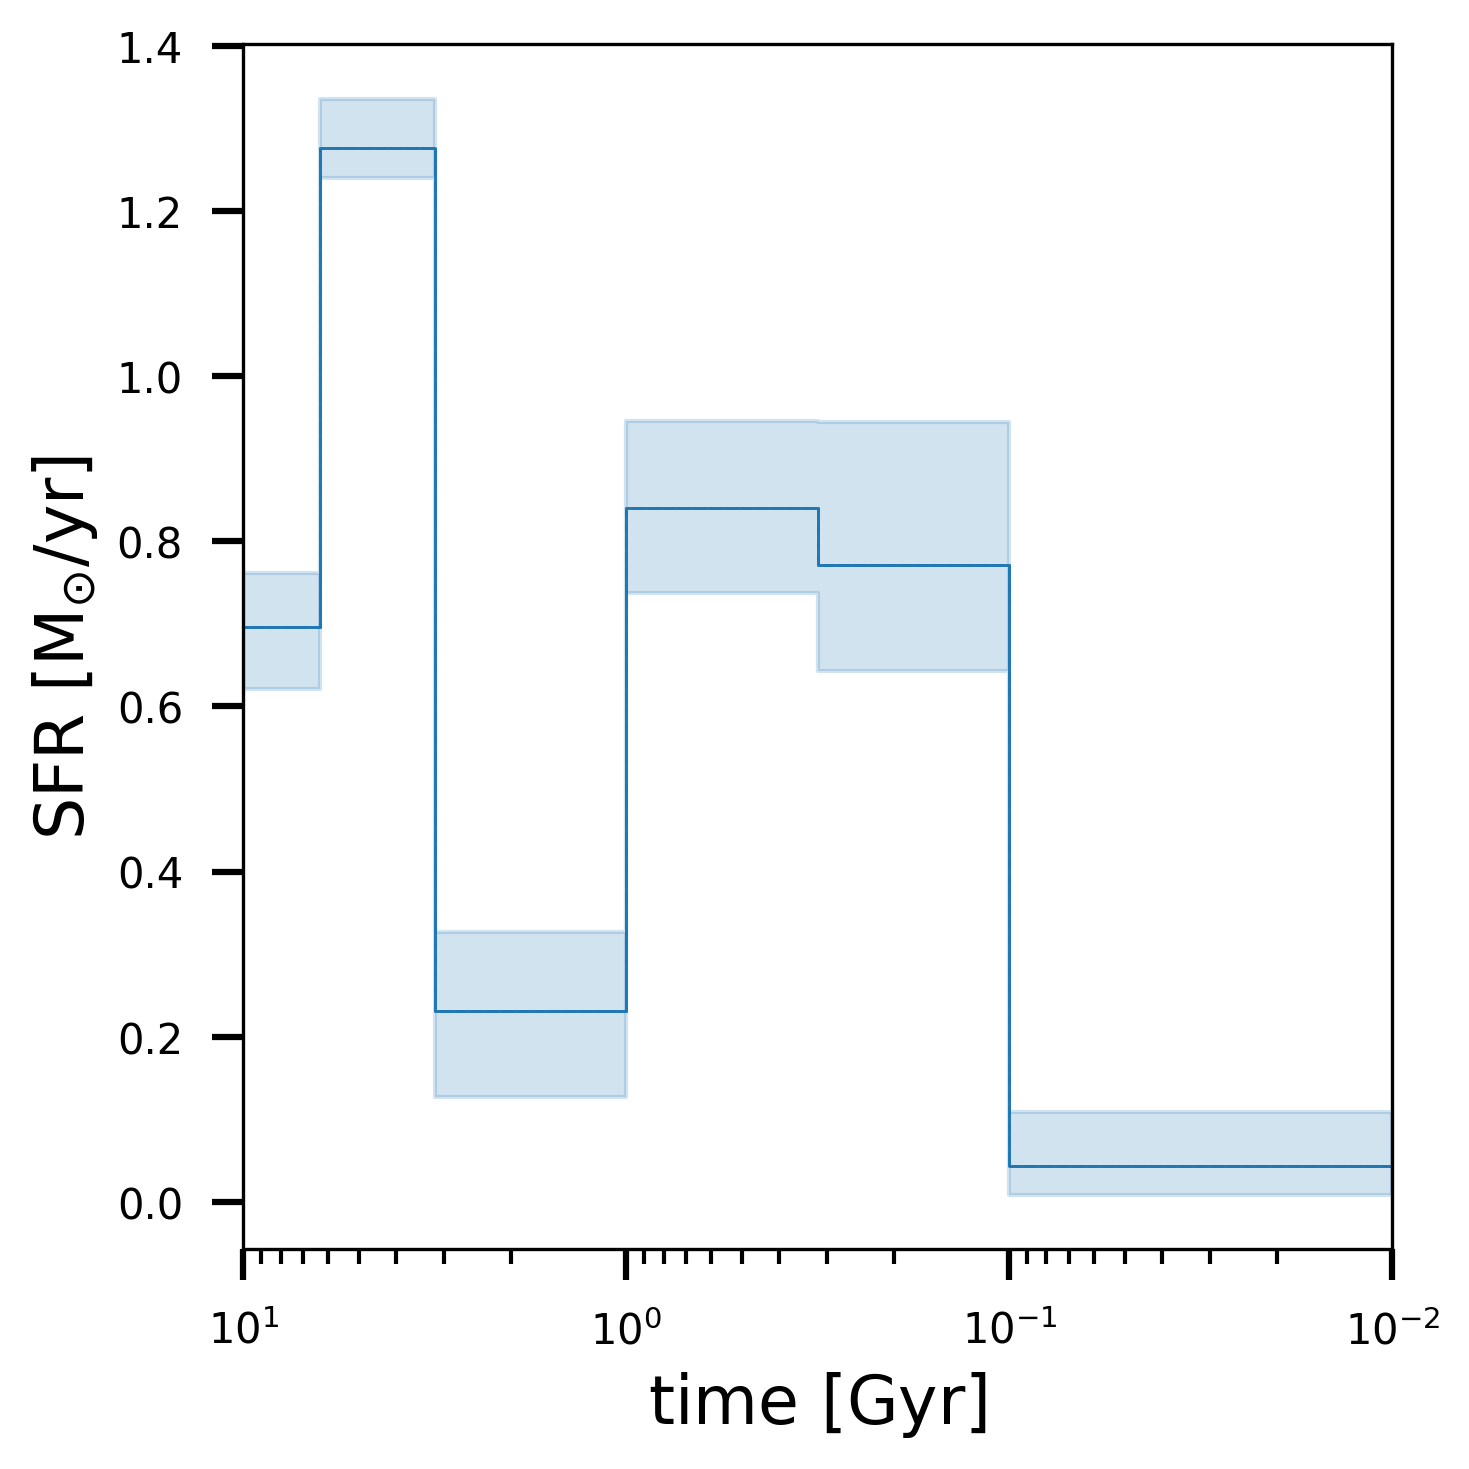

In [ ]:
### See SFR plot for specific galaxy ###
fig = figure(figsize=(5, 5), dpi = 300) #, dpi = 250)
ax=fig.add_subplot(1,1,1)

# Initialize the lists 
age_GYR = [None] * len(Specific_galaxy_index)
sfh_agebins = [None] * len(Specific_galaxy_index)
total_mass_q50 = [None] * len(Specific_galaxy_index)
total_mass_bestfit = [None] * len(Specific_galaxy_index)
sfr1_q = [None] * len(Specific_galaxy_index)
sfr_upper_q1 = [None] * len(Specific_galaxy_index)
sfr_lower_q1 = [None] * len(Specific_galaxy_index)
sfr1_bestfit = [None] * len(Specific_galaxy_index)

# Iterate through the runs for specific galaxy and plot SFR
for i in range(0, len(Specific_galaxy_index)):
    chain_shape = all_results[Specific_galaxy_index[i]]['chain'].shape

    if all_results[Specific_galaxy_index[i]]['chain'].ndim > 2:
        flatchain = all_results[Specific_galaxy_index[i]]['chain'].reshape(chain_shape[0] * chain_shape[1], chain_shape[2])

    # Convert agelims to GYR and make first element nonzero
    age_GYR[i] = np.power(10, all_results[Specific_galaxy_index[i]]['run_params']['agelims'])/1e9       # agebins in GYR
    age_GYR[i][0] = 1e-2                                       # Make first element nonzero to avoid squishing plot

    sfh_agebins[i] = all_results[Specific_galaxy_index[i]]['run_params']['agebins_init']
    theta_labels = all_results[Specific_galaxy_index[i]]['theta_labels']

    # Pull out zfraction elements from theta_labels
    zfrac_list = np.array([])
    for label in range(0, len(theta_labels)):
        if theta_labels[label][:10] == 'z_fraction':
            zfrac_list = np.append(zfrac_list, label)

    zfrac_list = zfrac_list.astype(int).tolist()
    z_frac_num = np.array([theta_labels[k] for k in range (len (theta_labels)) if k in zfrac_list])

    # Create a array of indicies from number of z_fractions
    id_zfrac = np.nonzero(z_frac_num)[0]             

    # Fill empty arrays with quantile values and bestfit theta
    q_50 = np.empty(len(id_zfrac))
    dx_up = np.empty(len(id_zfrac))
    dx_down = np.empty(len(id_zfrac))
    z_frac_bestfit = np.empty(len(id_zfrac))
    for k in id_zfrac:
        q_50[k], dx_up[k], dx_down[k] = best_vals(flatchain.T[k+1])
        z_frac_bestfit[k] = theta_bestfit[i][k+1]

    # Define zfrac array and top and bottom limits
    z_frac = q_50
    z_frac_upper = q_50 + dx_up
    z_frac_lower = q_50 - dx_down

    # Find total mass for zfrac_to_sfr
    total_mass_q50[i] = best_vals(flatchain.T[13])[0] 
    total_mass_bestfit[i] = theta_bestfit[i][13] 

    # Convert zfractions to sfr
    sfr_quant = zfrac_to_sfr(total_mass_q50[i], z_frac, sfh_agebins[i])               # use logmass?
    sfr_upper_quant = zfrac_to_sfr(total_mass_q50[i], z_frac_upper, sfh_agebins[i])
    sfr_lower_quant = zfrac_to_sfr(total_mass_q50[i], z_frac_lower, sfh_agebins[i])
    ssfr_quant = sfr_quant/total_mass_q50[i]

    sfr_bestfit = zfrac_to_sfr(total_mass_bestfit[i], z_frac, sfh_agebins[i])
    ssfr_bestfit = sfr_bestfit/total_mass_bestfit[i]

    # Append last element to array to see full sfr in plot
    sfr1_q[i] = np.append(sfr_quant, sfr_quant[-1])                   
    sfr_upper_q1[i] = np.append(sfr_upper_quant, sfr_upper_quant[-1])
    sfr_lower_q1[i] = np.append(sfr_lower_quant, sfr_lower_quant[-1])
    sfr1_bestfit[i] = np.append(sfr_bestfit, sfr_bestfit[-1])

    # Plot SFR in a step function and fill quantiles
    step(age_GYR[i], sfr1_q[i], where='post', color=my_cmap[i], linestyle='-')
    step(age_GYR[i], sfr1_bestfit[i], where='post', color=my_cmap[i], linestyle='--')
    fill_between(age_GYR[i], sfr_lower_q1[i], sfr_upper_q1[i], color=my_cmap[i], alpha = 0.2, step='post')


xscale('log')
ylabel(r'$\rm{SFR\ [M_{\odot}/yr]}$', fontsize=16)
xlabel(r'$\rm{time\ [Gyr]}$', fontsize=16)
xlim(10, 1e-2)

# title('{0}_SFH_6'.format(all_results[Specific_galaxy]['run_params']))

tight_layout()

# savefig(Galaxy_Path + '{0}_SFH_6'.format(all_results[Specific_galaxy]['run_params']))
# Change to a comparison folder and save by specific galaxy

In [ ]:
### Table for specific Galaxy ###
pandas.options.display.float_format = "{:.2e}".format
pandas.DataFrame([theta_bestfit[i] for i in Specific_galaxy_index], index= [G_names[i] for i in Specific_galaxy_index], columns=all_results[0]['theta_labels']).T

,G25
logmass,1.02e+01
z_fraction_1,9.99e-01
z_fraction_2,7.70e-01
z_fraction_3,7.22e-01
z_fraction_4,8.58e-01
z_fraction_5,3.18e-01
dust2,3.78e-01
logzsol,-2.30e-01
dust_index,-9.21e-01
dust1_fraction,1.40e+00


In [ ]:
### Table of all runs for all galaxies with data ###
pandas.options.display.float_format = "{:.2e}".format
pandas.DataFrame(theta_bestfit, index=G_names, columns=all_results[0]['theta_labels']).T

# Fagn ~ 0 when < 0.05

,G25
logmass,1.02e+01
z_fraction_1,9.99e-01
z_fraction_2,7.70e-01
z_fraction_3,7.22e-01
z_fraction_4,8.58e-01
z_fraction_5,3.18e-01
dust2,3.78e-01
logzsol,-2.30e-01
dust_index,-9.21e-01
dust1_fraction,1.40e+00


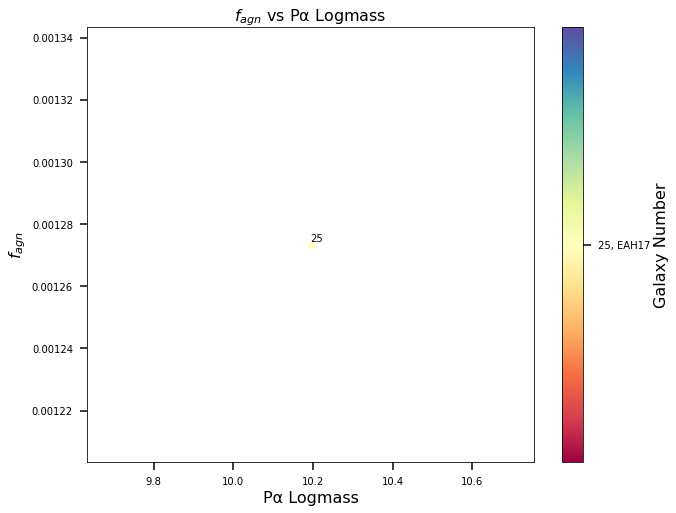

In [ ]:
### Plot Simulated f_AGN Values vs Simulated Logmass ###
fig = figure(figsize=(10,8))
logmass = [lmass[0] for lmass in theta_bestfit]
fagn = [f_agn[14] for f_agn in theta_bestfit]

scatter(logmass, fagn, c=G_numbers, cmap='Spectral')

cbar = colorbar(ticks = G_numbers)
cbar.set_ticklabels(['{0}, {1}'.format(G_numbers[i], Gal_desig[i]) for i in range(0, len(G_numbers))])
cbar.set_label(label='Galaxy Number', size=16)

xlabel('Pα Logmass', size=16)
ylabel('$f_{agn}$', size= 16)
title('$f_{agn}$ vs Pα Logmass', size=16)
offset = .000001

for i, txt in enumerate(G_numbers):
    annotate(txt, (logmass[i] + offset, fagn[i] + offset))

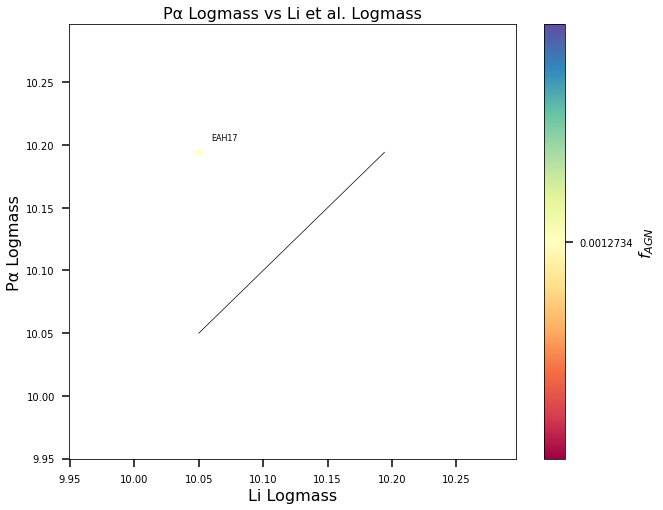

In [ ]:
### Plot Pα Simulated Logmass vs Li et al Logmass ### 
logmass_min = min(logmass + Gal_logmass)
logmass_max = max(logmass + Gal_logmass)
logmass_line_lin = np.linspace(logmass_min, logmass_max, num=100)

fig = figure(figsize=(10,8))
scatter(Gal_logmass, logmass, c=fagn, cmap='Spectral')
# scatter(Gal_logmass, logmass, c=G_numbers, cmap='Spectral')

plot(logmass_line_lin, logmass_line_lin, 'k')

cbar = colorbar(ticks = fagn)
# cbar = colorbar(ticks = G_numbers)

# cbar.set_ticklabels(['{0}, {1}'.format(G_numbers[i], Gal_desig[i]) for i in range(0, len(G_numbers))])
# cbar.set_label(label='Galaxy Number', size=16)
cbar.set_label(label='$f_{AGN}$', size=16)

title('Pα Logmass vs Li et al. Logmass', size=16)
ylabel('Pα Logmass', size=16)
xlabel('Li Logmass', size= 16)
xlim(logmass_min * 0.99, logmass_max * 1.01)
ylim(logmass_min * 0.99, logmass_max * 1.01)

offset = .01
for i, txt in enumerate(G_numbers):
    # print(i)
    annotate(Gal_desig[i], (Gal_logmass[i] + offset, logmass[i] + offset), size = 8)        #str(txt) + ','+ 

# https://github.com/bd-j/prospector/issues/151  <-- Mass is too large

In [ ]:
### Load in SDSS Data ###
# G0 - G8: R1 - R10:  https://academic.oup.com/mnras/article/448/1/258/1748852 
# G9- G25: EAH01 - EAH17: https://iopscience.iop.org/article/10.1088/0004-637X/801/1/1 
# G27 - G431: EAS01 - EAS15: https://iopscience.iop.org/article/10.1088/0004-637X/801/1/1 
# No data for G26 (EAH18) and G42 - G57 (F34-37, A1-12)
SDSS_Logmass_R = [9.8, 10.7, 9.6, 10.4, 9.9, 10.4, 10.2, 10.3, 10.2]
SDSS_Logmass_EAH = [10.45, 9.96, 10.34, 10.18, 10.00, 10.53, 10.65, 10.41, 10.21, 10.24, 10.61, 10.55, 11.00, 10.04, 10.40, 10.74, 10.05]
SDSS_Logmass_EAH18 = [np.inf]
SDSS_Logmass_EAS = [10.24, 10.08, 10.86, 9.99, 10.57, 10.14, 10.54, 10.67, 10.56, 10.53, 10.74, 10.01, 10.95, 11.31, 10.83]

num_empty = 58 - (len(SDSS_Logmass_R) + len(SDSS_Logmass_EAH) + len(SDSS_Logmass_EAS) + len(SDSS_Logmass_EAH18))
SDSS_Logmass_F_A = np.inf * np.ones(num_empty)

SDSS_Logmass = SDSS_Logmass_R + SDSS_Logmass_EAH + SDSS_Logmass_EAH18 + SDSS_Logmass_EAS + SDSS_Logmass_F_A.tolist()

SDSS_Logmass = np.array(SDSS_Logmass)
Logmass_mask = np.isfinite(SDSS_Logmass)

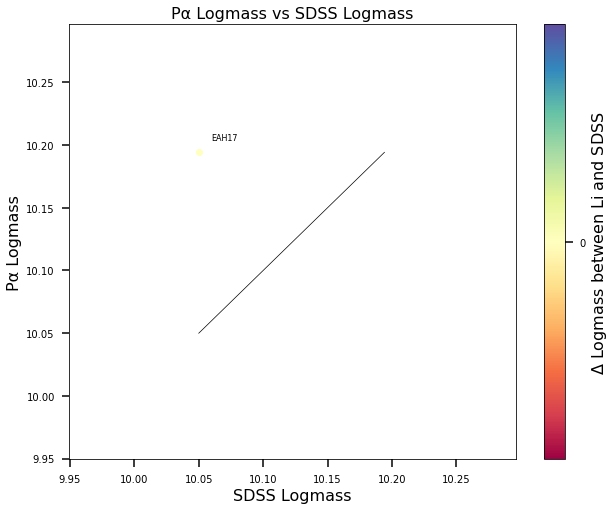

In [ ]:
### Plot Pα Simulated Logmass vs SDSS Logmass ###
counter = 0
sorted_SDSS_logmass_4SDSS = []
sorted_Pa_logmass_4SDSS = []
sorted_Li_logmass_4SDSS = []
sorted_G_numbers_4SDSS = []
sorted_Pa_logmass = []
for i in G_numbers:
    if Logmass_mask[i] == True:
        sorted_G_numbers_4SDSS.append(i)
        sorted_SDSS_logmass_4SDSS.append(SDSS_Logmass[i])
        sorted_Pa_logmass_4SDSS.append(logmass[counter])
        sorted_Li_logmass_4SDSS.append(Gal_logmass[counter])
        sorted_Pa_logmass.append(logmass[counter])
    counter += 1

sorted_SDSS_logmass_4SDSS = np.array(sorted_SDSS_logmass_4SDSS)
sorted_Li_logmass_4SDSS = np.array(sorted_Li_logmass_4SDSS)
sorted_Pa_logmass_4SDSS = np.array(sorted_Pa_logmass_4SDSS)
sorted_G_numbers_4SDSS = np.array(sorted_G_numbers_4SDSS)


fig = figure(figsize=(10,8))

xlim(logmass_min * 0.99, logmass_max * 1.01)
ylim(logmass_min * 0.99, logmass_max * 1.01)

title('Pα Logmass vs SDSS Logmass', size=16)
ylabel('Pα Logmass', size=16)
xlabel('SDSS Logmass', size= 16)

plot(logmass_line_lin, logmass_line_lin, 'k')
scatter(sorted_SDSS_logmass_4SDSS, sorted_Pa_logmass, c=(sorted_Li_logmass_4SDSS - sorted_SDSS_logmass_4SDSS), cmap='Spectral')

cbar = colorbar(ticks = (sorted_Li_logmass_4SDSS - sorted_SDSS_logmass_4SDSS))
cbar.set_label(label=r'$\Delta$ Logmass between Li and SDSS', size=16)


for i, txt in enumerate(sorted_G_numbers_4SDSS):
    annotate(Gal_desig[i], (sorted_SDSS_logmass_4SDSS[i] + offset, logmass[i] + offset), size = 8)        #str(txt) + ','+ 

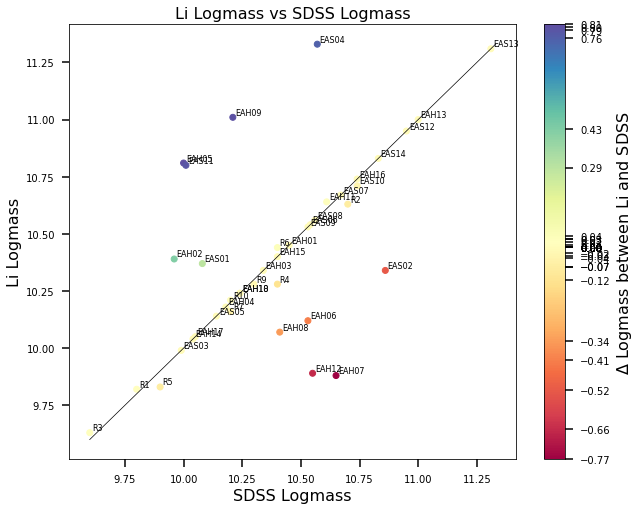

In [ ]:
### Compare Li et al Logmass to SDSS Logmass ###
All_Li_logmass = []
SDSS_G_numbers = []
All_G_desig = []

for i in range(0, 58):
    All_Li_logmass.append(AGN_data[i][50])
    SDSS_G_numbers.append(i)
    All_G_desig.append(AGN_data[i][1])

All_Li_logmass = np.array(All_Li_logmass)
SDSS_G_numbers = np.array(SDSS_G_numbers)

All_SDSS_Logmass = SDSS_Logmass[Logmass_mask]
All_Li_logmass = All_Li_logmass[Logmass_mask]
SDSS_G_numbers = SDSS_G_numbers[Logmass_mask]

SDSS_logmass_min = min(min(All_SDSS_Logmass), min(All_Li_logmass))
SDSS_logmass_max = max(max(All_SDSS_Logmass), max(All_Li_logmass))
SDSS_logmass_line_lin = np.linspace(SDSS_logmass_min, SDSS_logmass_max, num=100)

fig = figure(figsize=(10,8))

title('Li Logmass vs SDSS Logmass', size=16)
ylabel('Li Logmass', size=16)
xlabel('SDSS Logmass', size= 16)

plot(SDSS_logmass_line_lin, SDSS_logmass_line_lin, 'k')
scatter(All_SDSS_Logmass, All_Li_logmass, c=(All_Li_logmass - All_SDSS_Logmass), cmap='Spectral')

cbar = colorbar(ticks = (All_Li_logmass - All_SDSS_Logmass))
cbar.set_label(label=r'$\Delta$ Logmass between Li and SDSS', size=16)


for i, txt in enumerate(SDSS_G_numbers):
    annotate(All_G_desig[i], (All_SDSS_Logmass[i] + offset, All_Li_logmass[i] + offset), size = 8)        #str(txt) + ','+ 

In [ ]:
end_time = time.time()
print('This program takes:\n\t',end_time - start_time, '\tsecs\n\t', (end_time - start_time)/60, '\tmins\n\t', (end_time - start_time)/60/60, '\thours')

This program takes:
	 542.1460793018341 	secs
	 9.035767988363903 	mins
	 0.15059613313939837 	hours
